In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import re

from scipy import stats

# TO-DO

1) Округление в int количество товаров в monthly_sales и сравнить результаты такого изменения на модели

In [2]:
# Data fields
# ID - an Id that represents a (Shop, Item) tuple within the test set
# shop_id - unique identifier of a shop
# item_id - unique identifier of a product
# item_category_id - unique identifier of item category
# item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
# item_price - current price of an item
# date - date in format dd/mm/yyyy
# date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
# item_name - name of item
# shop_name - name of shop
# item_category_name - name of item category

In [4]:
shops_df = pd.read_csv("data/shops.csv") 
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [5]:
items_df = pd.read_csv("data/items.csv") 
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
item_categories_df = pd.read_csv("data/item_categories.csv") 
item_categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
#  the test set. You need to forecast the sales for these shops and products for November 2015.
test = pd.read_csv("data/test.csv") 
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [8]:
# a sample submission file in the correct format.
sample_submission = pd.read_csv("data/sample_submission.csv") 
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5



# DQC layer

In [4]:
# The training set. Daily historical data from January 2013 to October 2015.
sales_train = pd.read_csv("data/sales_train.csv", parse_dates=["date"], dayfirst=True)  
print(sales_train.shape)
sales_train.head(3)

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
1,2013-01-03,0,25,2552,899.0,1.0
2,2013-01-05,0,25,2552,899.0,-1.0


In [7]:
type(sales_train["date"])

pandas.core.series.Series

In [10]:
sales_train["date"] = sales_train["date"].astype("int64")

In [11]:
# DataFrame info (dtypes, memory etc.)
sales_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            int64  
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(4)
memory usage: 134.4 MB


In [12]:
# descriptive statistics to the DF columns
sales_train.describe()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.396504e+18,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,2.478812e+16,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,1.356998e+18,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,1.375315e+18,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.393891e+18,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,1.417738e+18,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,1.446250e+18,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


#### Пометки в результате изучения описательных статистик (в столбцах item_price и item_cnt_day)
1) Среднее значительно больше медианы (0.5-го перцентиля)

2) Максимальное значение сильно больше (0.75-го перцентиля)

Первое и второе наблюдение говорит о наличии выбросов в данных полях.

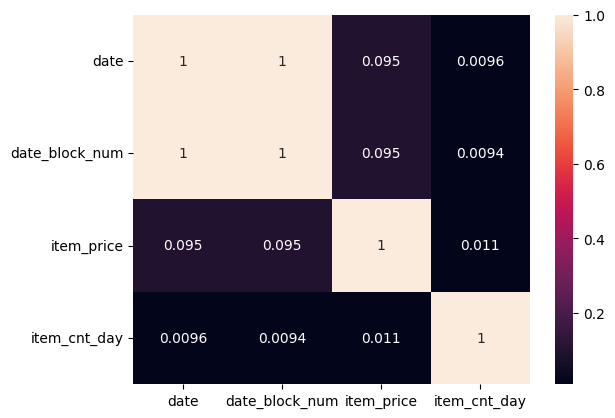

In [13]:
# EDA
sales_train_corr = sales_train[["date", "date_block_num", "item_price", "item_cnt_day"]].corr(numeric_only=True)
sns.heatmap(sales_train_corr, annot=True)
plt.show()

In [12]:
# sns.set()
# sns.pairplot(sales_train[["date", "date_block_num", "item_price", "item_cnt_day"]], height = 2.5)
# plt.show();

In [14]:
# outliers check (for item_price and item_cnt_day columns)
columns_to_check = ["item_price", "item_cnt_day"]
columns_outliers = {"outliers_idxs" : {}, "iqr_interval":{}} # dictionary for storing outliers indexes (for processing) 
                                                    # and iqr interval borders (for visualization)
for column in columns_to_check:
    # iqr interval calculating 
    column_quartile1 = sales_train[column].quantile(.25)
    column_quartile3 = sales_train[column].quantile(.75)
    column_iqr = column_quartile3 - column_quartile1

    column_interval_border1 = column_quartile1 - 1.5 * column_iqr
    column_interval_border2 = column_quartile3 + 1.5 * column_iqr
    columns_outliers["iqr_interval"][column] = (column_interval_border1, column_interval_border2)
    # outliers search
    outliers_idxs = sales_train.loc[(sales_train[column] < column_interval_border1) | (sales_train[column] > column_interval_border2)].index
    columns_outliers["outliers_idxs"][column] = outliers_idxs

    print(f"{len(outliers_idxs)} outliers were found for the {column} column.")

258942 outliers were found for the item_price column.
306477 outliers were found for the item_cnt_day column.


In [15]:
columns_outliers["outliers_idxs"].keys()

dict_keys(['item_price', 'item_cnt_day'])

In [16]:
type(columns_outliers["outliers_idxs"]["item_price"])

pandas.core.indexes.numeric.Int64Index

### item_price and item_cnt_day columns visualization

In [17]:
item_price_interval_border_1 = columns_outliers["iqr_interval"]["item_price"][0]
item_price_interval_border_2 = columns_outliers["iqr_interval"]["item_price"][1]

item_price_wo_outliers = sales_train.loc[(sales_train["item_price"] >= item_price_interval_border_1) & (sales_train["item_price"] <= item_price_interval_border_2)]["item_price"]

In [18]:
item_cnt_day_interval_border_1 = columns_outliers["iqr_interval"]["item_cnt_day"][0]
item_cnt_day_interval_border_2 = columns_outliers["iqr_interval"]["item_cnt_day"][1]

item_cnt_day_wo_outliers = sales_train.loc[(sales_train["item_cnt_day"] >= item_cnt_day_interval_border_1) & (sales_train["item_cnt_day"] <= item_cnt_day_interval_border_2)]["item_cnt_day"]

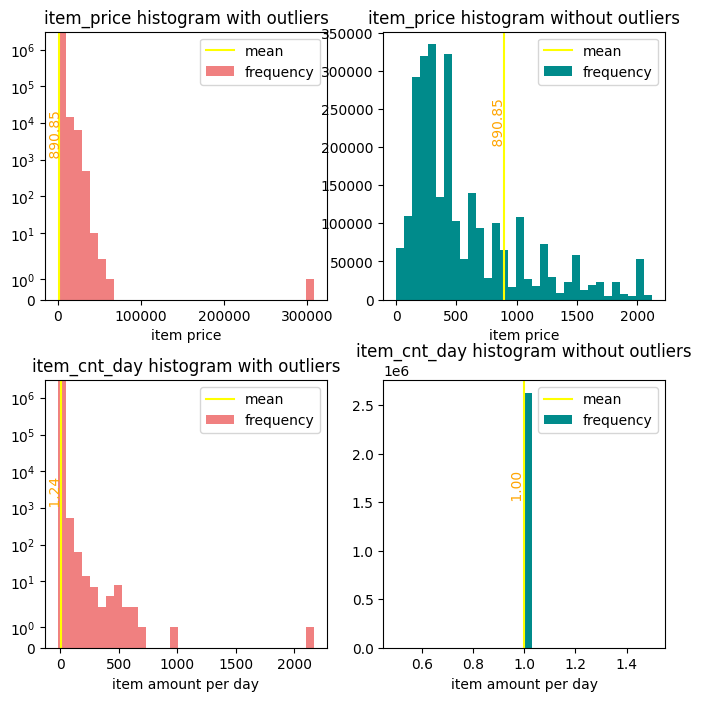

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(hspace=0.3)

ax[0][0].hist(sales_train["item_price"], bins=32, color="lightcoral")
ax[0][1].hist(item_price_wo_outliers, bins=32, color="darkcyan")
ax[0][0].axvline(sales_train["item_price"].mean(), color="yellow")
ax[0][1].axvline(sales_train["item_price"].mean(), color="yellow")

ax[0][0].text(sales_train["item_price"].mean() - 12000, 1000, s=f"{sales_train['item_price'].mean() : .2f}", rotation=90, color="orange")
ax[0][1].text(sales_train["item_price"].mean() - 100, 200000, s=f"{sales_train['item_price'].mean() : .2f}", rotation=90, color="orange")

ax[0][0].legend(["mean", "frequency"])
ax[0][1].legend(["mean", "frequency"])

ax[0][0].set_title("item_price histogram with outliers")
ax[0][1].set_title("item_price histogram without outliers")

ax[0][0].set_xlabel("item price")
ax[0][1].set_xlabel("item price")
#
ax[1][0].hist(sales_train["item_cnt_day"], bins=32, color="lightcoral")
ax[1][1].hist(item_cnt_day_wo_outliers, bins=32, color="darkcyan")
ax[1][0].axvline(item_cnt_day_wo_outliers.mean(), color="yellow")
ax[1][1].axvline(item_cnt_day_wo_outliers.mean(), color="yellow")

ax[1][0].text(item_cnt_day_wo_outliers.mean() - 100, 1000, s=f"{sales_train['item_cnt_day'].mean() : .2f}", rotation=90, color="orange")
ax[1][1].text(item_cnt_day_wo_outliers.mean() - 0.05, 1500000, s=f"{item_cnt_day_wo_outliers.mean().mean() : .2f}", rotation=90, color="orange")

ax[1][0].legend(["mean", "frequency"])
ax[1][1].legend(["mean", "frequency"])

ax[1][0].set_title("item_cnt_day histogram with outliers")
ax[1][1].set_title("item_cnt_day histogram without outliers")

ax[1][0].set_xlabel("item amount per day")
ax[1][1].set_xlabel("item amount per day")

ax[0][0].set_yscale("symlog")
ax[1][0].set_yscale("symlog")

plt.show()

#### Normal distribution check

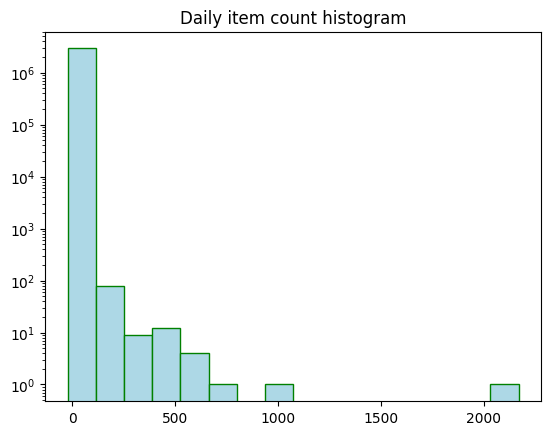

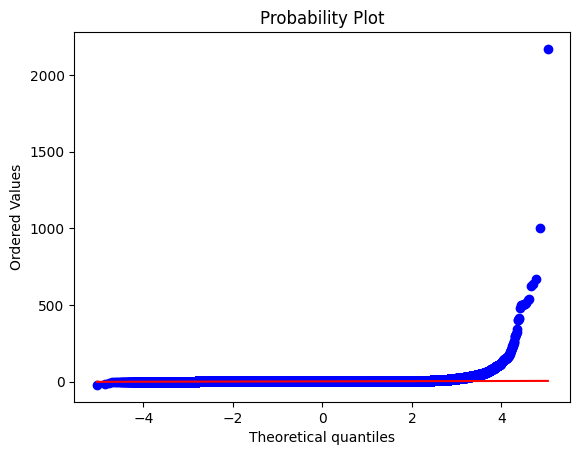

In [66]:
# EDA
plt.hist(sales_train["item_cnt_day"], bins=16, edgecolor="green", color="lightblue")
plt.yscale("log")
plt.title("Daily item count histogram")
plt.show()
fig = plt.figure()
res = stats.probplot(sales_train["item_cnt_day"], plot=plt)
plt.show()

In [1]:
# EDA
plt.hist(sales_train["item_price"], bins=16, edgecolor="green", color="lightblue")
plt.yscale("log")
plt.title("Item price histogram")
plt.show()
fig = plt.figure()
res = stats.probplot(sales_train["item_price"], plot=plt)
plt.show()

NameError: name 'plt' is not defined

In [20]:
# ids availibility check (OFF THE DQC AND ETL CLASSES)
missing_item_ids_idx = sales_train[~sales_train["item_id"].isin(items_df["item_id"])].index
missing_shop_ids_idx = sales_train[~sales_train["shop_id"].isin(shops_df["shop_id"])].index
missing_item_categories_idx = items_df[~items_df["item_category_id"].isin(item_categories_df["item_category_id"])].index

print(f"Row indexes of missing sales_train item ids in items_df: {list(missing_item_ids_idx)}")
print(f"Row indexes of missing sales_train shop ids in shops_df: {list(missing_shop_ids_idx)}")
print(f"Row indexes of missing items_df item categories id in item_categories_df: {list(missing_item_categories_idx)}")

Row indexes of missing sales_train item ids in items_df: []
Row indexes of missing sales_train shop ids in shops_df: []
Row indexes of missing items_df item categories id in item_categories_df: []


In [21]:
# NA values check
na_rows = sales_train[sales_train.isna().any(axis=1)] # rows with NA values 
na_rows_idx = na_rows.index # rows indexes with NA values 
print(f"Number of rows with missing values: {len(na_rows_idx)}")

Number of rows with missing values: 0


In [22]:
# data consistency and data uniqueness check
items_without_cnt_df = sales_train.loc[:, ["date", "date_block_num", "shop_id", "item_id", "item_price"]]
inconsistent_rows = items_without_cnt_df[items_without_cnt_df.duplicated()] # searching for identical rows, but with different values for the column item_cnt_day
inconsistent_rows_rows_idx = inconsistent_rows.index # indexes of identical rows

print(f"Number of conflicting and duplicated rows: {len(inconsistent_rows_rows_idx)}")

Number of conflicting and duplicated rows: 6


In [23]:
type(inconsistent_rows_rows_idx)

pandas.core.indexes.numeric.Int64Index

In [24]:
# data types check 
not_numeric_columns = []
not_date_columns = []
not_string_columns = []
for column_name in sales_train.columns:

    numeric_patterns = [r"(?:\w+|\b)id\b", r"(?:\w+|\b)price\b", r"(?:\w+|\b)num\b", r"(?:\w+|\b)cnt(?:\w+|\b)", r"(?:\w+|\b)amount(?:\w+|\b)"]
    date_patterns = [r"(?:\w+|\b)date\b"]
    string_patterns = [r"(?:\w+|\b)name\b"]

    numeric_patterns_check = [bool(re.search(pattern, column_name, flags=re.IGNORECASE)) for pattern in numeric_patterns] 
    date_patterns_check = [bool(re.search(pattern, column_name, flags=re.IGNORECASE)) for pattern in date_patterns]
    string_patterns_check = [bool(re.search(pattern, column_name, flags=re.IGNORECASE)) for pattern in string_patterns]

    if any(numeric_patterns_check):
        numeric_types = [int, float, np.int64, np.float64]

        numeric_check = [sales_train.dtypes[column_name] == ntype for ntype in numeric_types]
        if not any(numeric_check):
            not_numeric_columns.append(column_name)

    elif any(date_patterns_check):
        if not pd.api.types.is_datetime64_any_dtype(sales_train[column_name]):
            not_date_columns.append(column_name)

    elif any(string_patterns_check):
        if not sales_train.dtypes[column_name] == object:
            not_string_columns.append(column_name)
        
print(f"Сolumns with presumably the wrong data type: \nnot numeric type columns: {not_numeric_columns},\nnot date type columns: {not_date_columns},\nnot string type columns: {not_string_columns}")

Сolumns with presumably the wrong data type: 
not numeric type columns: [],
not date type columns: ['date'],
not string type columns: []


# ETL layer

In [25]:
# sales_train outliers processing (replacing outliers with the mean value for a specific column)
sales_train.loc[columns_outliers["outliers_idxs"]["item_price"], "item_price"] = sales_train["item_price"].mean()
sales_train.loc[columns_outliers["outliers_idxs"]["item_cnt_day"], "item_cnt_day"] = sales_train["item_cnt_day"].mean()

In [26]:
# drop not available ids (OFF THE DQC AND ETL CLASSES)
sales_train.drop(index=missing_item_ids_idx.union(missing_shop_ids_idx), inplace=True) # drop rows with not available ids

In [27]:
# drop rows with NA values
sales_train.drop(index=na_rows_idx, inplace=True)

In [28]:
# drop inconsistent and duplicated rows
sales_train.drop(index=inconsistent_rows_rows_idx, inplace=True)

In [29]:
# data type conversion 
# conversion numeric columns with not numeric data type 
for column_name in not_numeric_columns:
    try:
        sales_train[column_name] = sales_train[column_name].apply(np.int64)
    except error as e:
        raise e
# conversion date columns with not date data type         
for column_name in not_date_columns:
    try:
        sales_train[column_name] = pd.to_datetime(sales_train[column_name])
    except error as e:
        raise e
# conversion string columns with not string data type         
for column_name in not_string_columns:
    try:
        sales_train[column_name] = sales_train[column_name].apply(str)
    except error as e:
        raise e

In [30]:
# converting columns of different data types to the columns of the same data type (data validity)
for column in sales_train.columns:
    if sales_train.dtypes[column] == object: # we check columns with an object type, which could potentially be a column with data of different types
        
        expected_type = type(sales_train[column].iloc[0]) # take the value type of the first row
        try:
            sales_train = sales_train[column].apply(expected_type) # try to convert column samples with a wrong type into the right type (expected_type)
        except error as e:
            raise e

### Creating a monthly_sales dataframe based on the main sales_train
* It will include the monthly sales for each product for each store

In [20]:
# OFF THE ETL CLASS

In [31]:
# adding an Year-month column 
sales_train["month"] = sales_train["date"].dt.to_period("M")

In [70]:
# grouping data to calculate monthly amount for a specific item in a specific store
monthly_sales = sales_train.groupby(["month", "shop_id", "item_id"])["item_cnt_day"].sum() 

monthly_sales = pd.DataFrame(monthly_sales) # from pandas Series object into pandas DataFrame
    
monthly_sales = monthly_sales.rename(columns={'item_cnt_day': 'item_cnt_month'}) # item_cnt_day column rename 

monthly_sales = monthly_sales.reset_index() # converting indexes into columns

monthly_sales["month"] = monthly_sales["month"].dt.strftime("%Y-%m") # converting datetime type into str 
                                                                    # for data visualization (can be ignored)
# monthly_sales["month"] = monthly_sales["month"].astype("int64") # converting datetime type into int 

print(monthly_sales.shape)
monthly_sales.head(15)

(1609124, 4)


,month,shop_id,item_id,item_cnt_month
0,2013-01,0,32,4.485282
1,2013-01,0,33,3.000000
2,2013-01,0,35,1.000000
3,2013-01,0,43,1.000000
4,2013-01,0,51,2.000000
5,2013-01,0,61,1.000000
6,2013-01,0,75,1.000000
7,2013-01,0,88,1.000000
8,2013-01,0,95,1.000000
9,2013-01,0,96,1.000000


In [71]:
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   month           1609124 non-null  object 
 1   shop_id         1609124 non-null  int64  
 2   item_id         1609124 non-null  int64  
 3   item_cnt_month  1609124 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 49.1+ MB


In [30]:
monthly_sales.item_cnt_month.describe()

count    1.609124e+06
mean     1.870712e+00
std      2.176164e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.852187e+01
Name: item_cnt_month, dtype: float64

In [2]:
# --------------------------

## Данные для проверки на стационарность и АК и гетероскедастичность

In [61]:
# monthly data
monthly_sales_sum = monthly_sales.groupby(["month"])["item_cnt_month"].sum()
monthly_sales_sum = pd.DataFrame(monthly_sales_sum).reset_index()
monthly_sales_sum["month"] = monthly_sales_sum["month"].dt.strftime("%Y-%m")

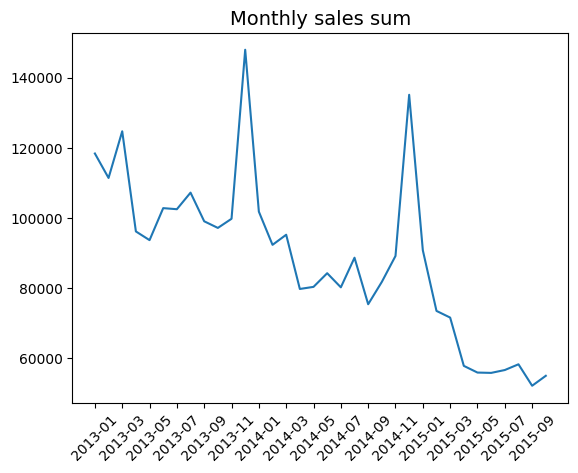

In [55]:
plt.plot(monthly_sales_sum.month, monthly_sales_sum.item_cnt_month)
plt.title("Monthly sales sum", fontsize=14)
plt.xticks(monthly_sales_sum["month"][::2], rotation=45)
plt.show()

In [58]:
# daily data
daily_sales_sum = sales_train.groupby(["date"])["item_cnt_day"].sum()
daily_sales_sum = pd.DataFrame(daily_sales_sum).reset_index()
daily_sales_sum["date"] = daily_sales_sum["date"].dt.strftime("%Y-%m-%d")

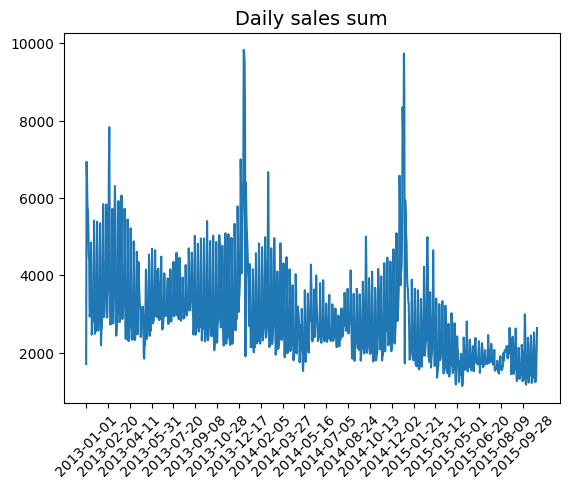

In [60]:
plt.plot(daily_sales_sum.date, daily_sales_sum.item_cnt_day)
plt.title("Daily sales sum", fontsize=14)
plt.xticks(daily_sales_sum["date"][::50], rotation=45)
plt.show()

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(monthly_sales.month, monthly_sales.item_cnt_month)
plt.title("Monthly sales", fontsize=14)
plt.xticks(monthly_sales["month"], rotation=45)
plt.show()


KeyboardInterrupt



## Проверка на гетероскедастичность

In [9]:
from typing import List
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

In [11]:
def heterosked_check(df, X_columns: List[str], y_column: str, significance_level: float=0.05) -> tuple:
    # Подготовка данных для модели
    X: pd.DataFrame = df[X_columns] 
    X: pd.DataFrame = sm.add_constant(X)  # Добавляем константу (свободный член, необходимый для теста БП)
    y: pd.Series = df[y_column]  

    # Обучаем модель линейной регрессии
    model: statsmodels.regression.linear_model.RegressionResultsWrapper = sm.OLS(y, X).fit()
    # Рассчитываем остатки
    predictions: pd.Series = model.predict(X)
    
    residuals: pd.Series = y - predictions
    # Применяем тест Бреуша-Пагана
    bp_test: tuple = het_breuschpagan(resid=residuals, exog_het=X)
    # Вывод результатов теста
    labels: List[str] = ['LM statistic', 'LM p-value', 'F-statistic', 'F p-value']
    bp_statistics: dict = dict(zip(labels, bp_test))
    
    heteroskedasticity: bool = False
    if (bp_statistics["LM p-value"] < significance_level) and (bp_statistics["F p-value"] < significance_level):
        heteroskedasticity = True
    
    return (heteroskedasticity, bp_statistics)

In [12]:
hr = heterosked_check(sales_train[:50], ["shop_id", "item_id"], "item_cnt_day")

print(hr)

<class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'tuple'>
(False, {'LM statistic': 1.4903250880519692, 'LM p-value': 0.47465714098656053, 'F-statistic': 0.721972258787393, 'F p-value': 0.4911017220304904})


In [ ]:
# ДЛЯ ЭТОГО СДЕЛАТЬ ПРОСТО НЕОБХОДИМЫЕ ДАТАСЕТЫ ГРУППИРОВКОЙ (эти же данные использовать для проверки стационарности)
# !!! Перед тем как проверять на АК ликвидировать для всех рядов (shop_item_item_cnt_month) нестационарность 

# ac check for season data (season (4 month) - item_cnt_sum)
# autocorrelation check for monthly data (month - item_cnt_sum)
# ac check for daily data (day - item_cnt_sum)
# Эти проверки необходимы только с аналитической точки зрения (например, для проверки наличия сезонности). 
# Для удовлетворительной *обработки* автокорреляции
# данных достаточно проверки для каждой уникальной пары магазин - предмет. В случае проверки данных на автокорреляцию
# в больших масштабах (например, для совокупное количество продаж для каждого месяца или для каждого магазина в каждом месяце)
#  и последующей обработки на базе этой проверки закономерность даннных может быть достаточно сильно искажена.

In [1]:
# ---------------------------

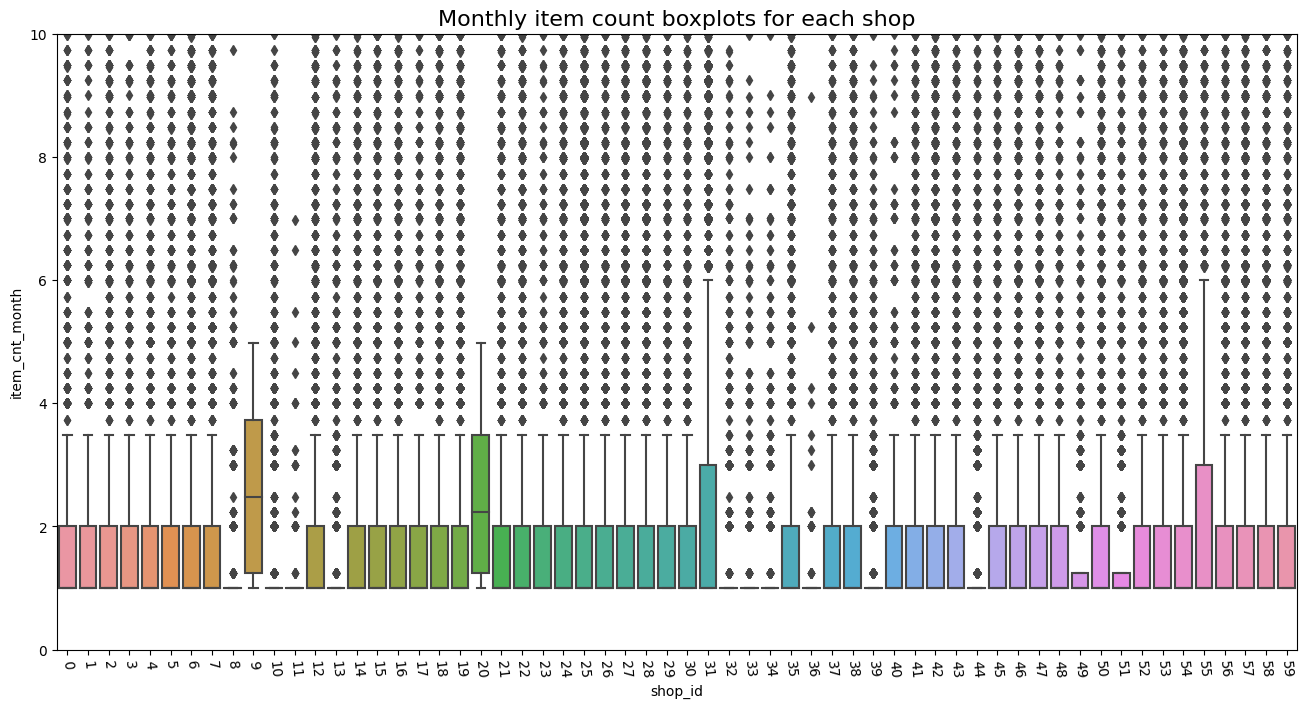

In [31]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x="shop_id", y="item_cnt_month", data=monthly_sales)
plt.title("Monthly item count boxplots for each shop", fontsize=16)
plt.xticks(rotation=275)
fig.axis(ymin=0, ymax=10);
plt.show()

#### Normal distribution check

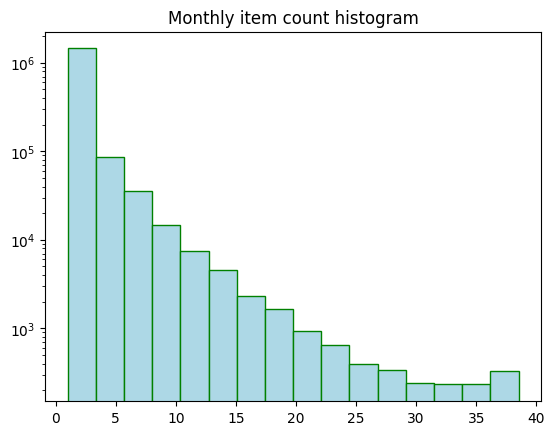

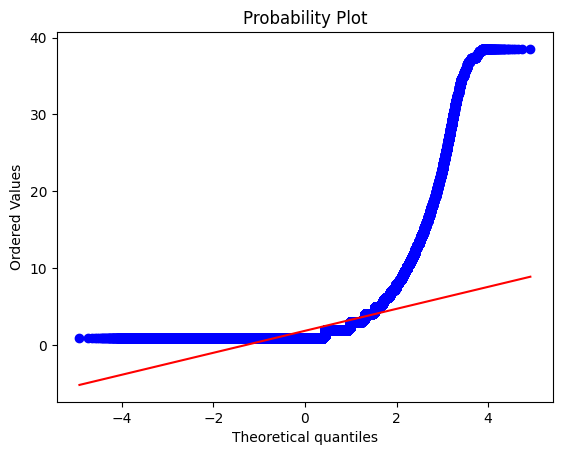

In [68]:
from scipy import stats

plt.hist(monthly_sales["item_cnt_month"], bins=16, edgecolor="green", color="lightblue")
plt.yscale("log")
plt.title("Monthly item count histogram")
plt.show()
fig = plt.figure()
res = stats.probplot(monthly_sales["item_cnt_month"], plot=plt)
plt.show()

In [32]:
q1 = monthly_sales["item_cnt_month"].quantile(.25)
q2 = monthly_sales["item_cnt_month"].quantile(.75)

iqr = q2 - q1 
border_1 = q1 - 1.5 * iqr
border_2 = q2 + 1.5 * iqr

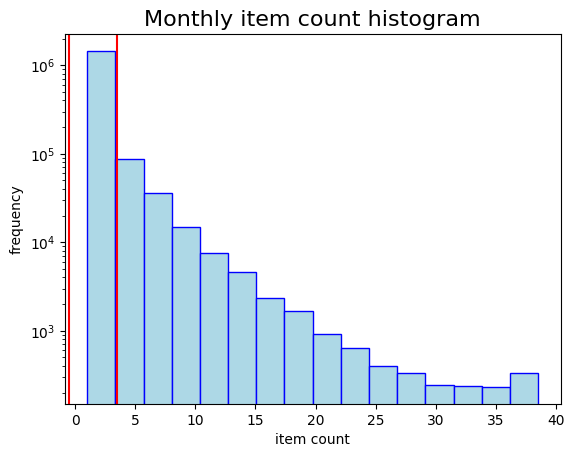

In [130]:
plt.hist(monthly_sales.item_cnt_month, edgecolor="blue", color="lightblue", bins=16)
plt.axvline(border_1, color="red")
plt.axvline(border_2, color="red")

plt.yscale("log")

plt.title("Monthly item count histogram", fontsize=16)

plt.xlabel("item count")
plt.ylabel("frequency")

plt.show()

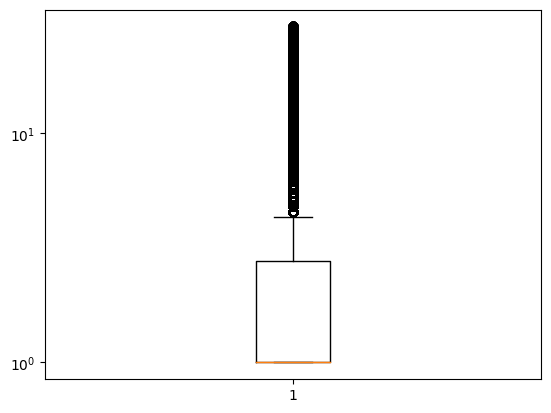

In [132]:
plt.boxplot(monthly_sales["item_cnt_month"])
plt.yscale("symlog")
plt.show()

In [133]:
monthly_item_cnt_outliers_idxs = monthly_sales.loc[(monthly_sales["item_cnt_month"] < border_1) | (monthly_sales["item_cnt_month"] > border_2), :].index 
print("The number of outliers in the 'item_cnt_month' column: ", len(monthly_item_cnt_outliers_idxs))

The number of outliers in the 'item_cnt_month' column:  153905


In [134]:
# drop item_cnt_month outliers 
monthly_sales.drop(index=monthly_item_cnt_outliers_idxs, inplace=True)
print("The number of droped rows: ", len(monthly_item_cnt_outliers_idxs))

The number of droped rows:  153905


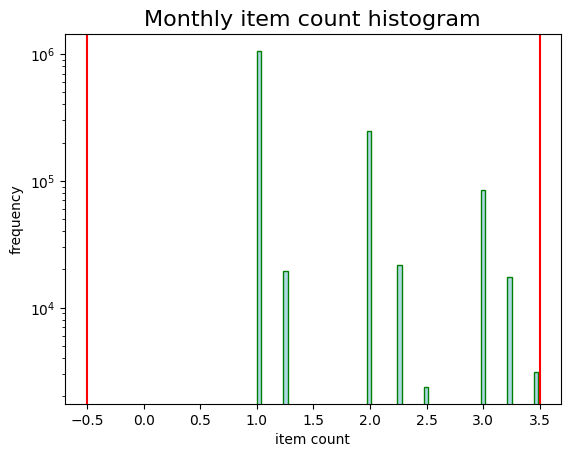

In [138]:
plt.hist(monthly_sales.item_cnt_month, edgecolor="green", color="lightblue", bins=32)
plt.axvline(border_1, color="red")
plt.axvline(border_2, color="red")

plt.yscale("log")

plt.title("Monthly item count histogram", fontsize=16)

plt.xlabel("item count")
plt.ylabel("frequency")

plt.show()

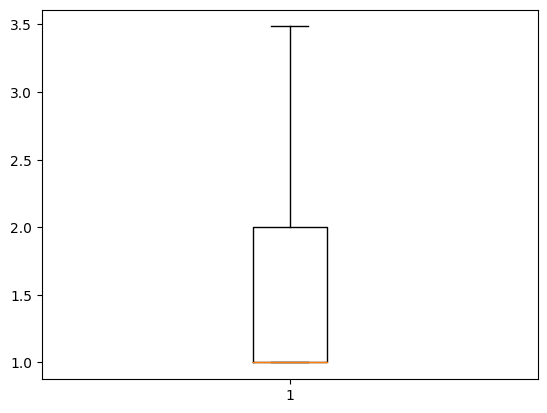

In [136]:
plt.boxplot(monthly_sales["item_cnt_month"])
plt.show()

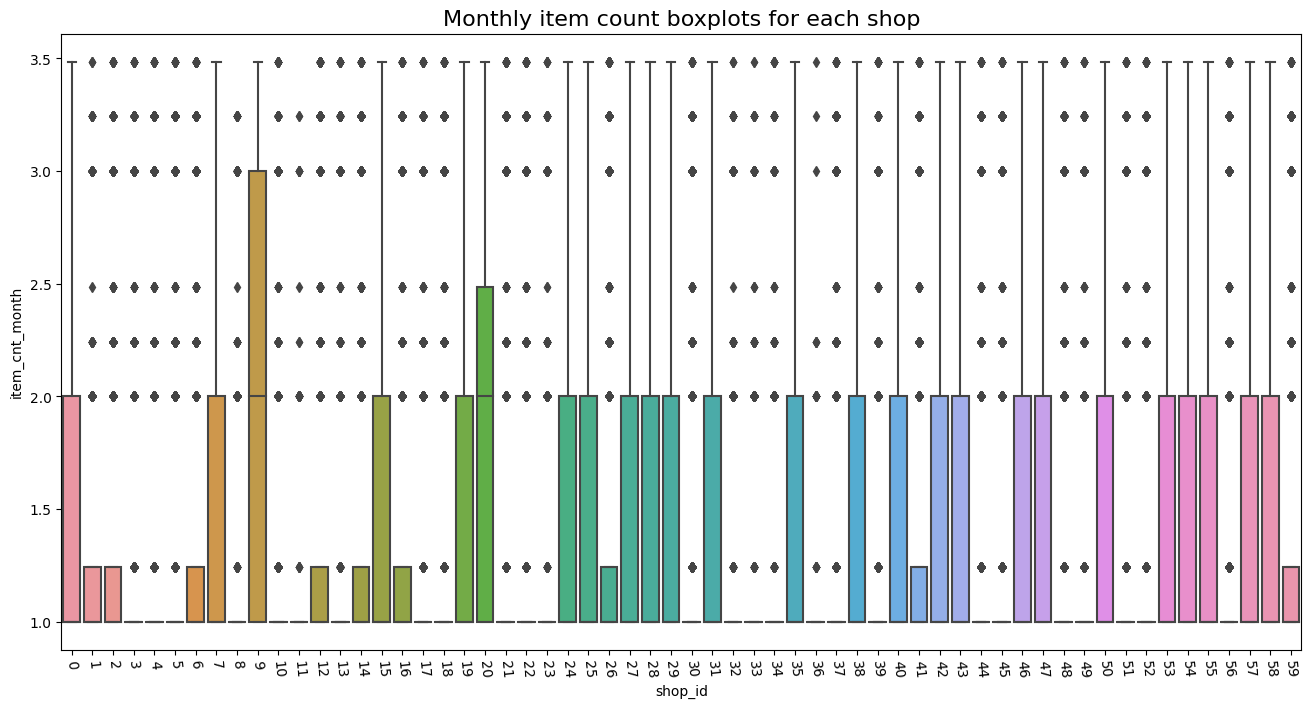

In [137]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x="shop_id", y="item_cnt_month", data=monthly_sales)
plt.title("Monthly item count boxplots for each shop", fontsize=16)
plt.xticks(rotation=275)
plt.show()

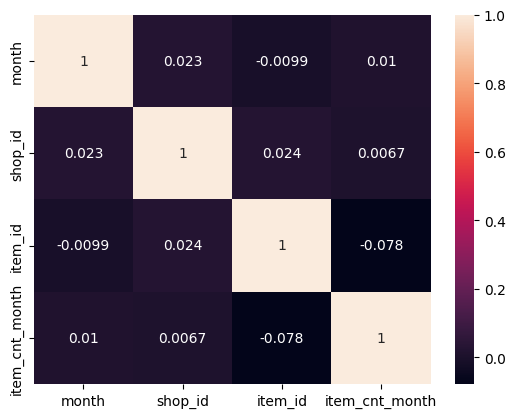

In [104]:
monthly_sales_corr = monthly_sales.corr(numeric_only=True)
sns.heatmap(monthly_sales_corr, annot=True)
plt.show()

In [ ]:
# sns.boxplot(x="shop_id", y="item_cnt_month", data=monthly_sales)
# plt.axis(ymin=0, ymax=6)
# plt.xticks(monthly_sales["shop_id"].unique()[::3])

### Loading data into the monthly_sales SQLite database

In [30]:
import sqlite3

with sqlite3.connect("data/monthly_sales.db") as db: 
    monthly_sales.to_sql("monthly_sales", db, index=False, if_exists="replace")

### Final data

In [35]:
# data can be divided into training and validation parts
X = monthly_sales.loc[:, ["shop_id", "item_id"]]
y = monthly_sales["item_cnt_month"]

In [36]:
X

,shop_id,item_id
0,0,32
1,0,33
2,0,35
3,0,43
4,0,51
...,...,...
1609119,59,22087
1609120,59,22088
1609121,59,22091
1609122,59,22100


In [37]:
y

0          4.485282
1          3.000000
2          1.000000
3          1.000000
4          2.000000
             ...   
1609119    3.485282
1609120    2.000000
1609121    1.000000
1609122    1.000000
1609123    1.000000
Name: item_cnt_month, Length: 1609124, dtype: float64